# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import h5py
from joblib import Parallel, delayed
import matplotlib.pyplot as pl
import numpy as np
import ringdown
import sys

## Import GW150914

Download data

In [3]:
#!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
#!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

In [4]:
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = ringdown.Data(h, index=t0 + dt*np.arange(len(h)), ifo=dname)
        
        return raw_strain
    
h_raw_strain = read_strain('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5', 'H1')
l_raw_strain = read_strain('L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5', 'L1')

## Cholesky-decomposition of the covariance matrix 

_NOTE:_ The decomposition might be expensive. But luckily, the result should be independent of the filter, so we can compute the result only once with the unfiltered data before iterating over the mass and spin.

In [5]:
def set_data(apply_filter=False, **kwargs):
    """Creates a :class:`Fit` instance for (un)filtered ringdown data
    
    .. note::
        Data are conditioned before the filter.
        
    Arguments
    ---------
    apply_filter : bool
        if false, don't apply the filter. This is typically used while 
        estimating the Cholesky-decomposition of the covariance matrix.
    
    kwargs : information of sky location, polarization anlge, conditioning.
    
    Returns
    ---------
    fit : Fit
        Ringdown :class:`Fit` object.
    """
    t_init = kwargs.pop("t_init")
    T = kwargs.pop("T")
    srate = kwargs.pop("srate")
    ra = kwargs.pop("ra")
    dec = kwargs.pop("dec")
    psi = kwargs.pop("psi")
    flow = kwargs.pop("flow")
    
    fit = ringdown.Fit(model='filter')
    fit.add_data(h_raw_strain)
    fit.add_data(l_raw_strain)
    fit.set_target(t_init, ra=ra, dec=dec, psi=psi, duration=T)
    fit.condition_data(ds=int(round(h_raw_strain.fsamp/srate)), flow=flow)
    
    if apply_filter:
        M_est = kwargs.pop("M_est")
        chi_est = kwargs.pop("chi_est")
        model_list = kwargs.pop("model_list")
        fit.filter_data(chi_est,M_est,model_list)
        
    return fit

In [6]:
def compute_L_inv(fit):
    """Perform the Cholesky decomposition of the covariance matrix
    by calling :meth:`Fit.compute_acfs`.
    
    Arguments
    ---------
    fit : Fit
        Ringdown :class:`Fit` object.
        
    Returns
    ---------
    Ls_inv : array
        The inverse of the decomposition matrix. 
    """
    fit.compute_acfs()
    Ls = fit.obtain_L()
    Ls_inv = []
    # Iterate over dectors
    for i in range(len(Ls)):
        inverse_Ls = np.linalg.inv(Ls[i])
        # Check that the matrix is properly inversed
        norm = np.sqrt(np.sum(abs(np.dot(inverse_Ls,Ls[i])
                                  -np.identity(len(Ls[i])))**2))
        if abs(norm)>1e-8:
            raise ValueError("Inverse of L is not correct")
        Ls_inv.append(inverse_Ls)
    return np.array(Ls_inv)

In [7]:
input = dict(model_list = [(1, -2, 2, 2, 0)],
             # trucation time (geocenter, in second)
             t_init = 1126259462.4083147+2.0*1e-3,
             # length of the analysis window (in second)
             T = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 2048,
             # sky localization and polarization angle
             ra = 1.95, dec = -1.27, psi = 0.82,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

In [8]:
fit = set_data(apply_filter=False, **input)
Ls_inv = compute_L_inv(fit)

## Likelihood as a function of mass and spin

In [9]:
def compute_likelihood(fit, Ls_inv):
    """Compute the likelihood
    
    Arguments
    ---------
    fit : Fit
        Ringdown :class:`Fit` object.
    
    Ls_inv : array
        The inverse of the Cholesky-decomposition of the covariance matrix.
        
    Returns
    ---------
    likelihood : float
        The likelihood of the detector network
    """
    wd = fit.analysis_data # obtain the whitened and filtered data
    strains = np.array([s.values for s in wd.values()])
    times = np.array([np.array(d.time) for d in wd.values()])
    likelihood = 0
    
    # Iterate over dectors
    for i in range(len(strains)):
        whitened = np.dot(Ls_inv[i], strains[i])
        likelihood -= 0.5*np.dot(whitened, whitened)
        
    return likelihood

def likelihood_vs_mass_spin(Ls_inv, M_est, chi_est, **kwargs):
    """Update the remannt mass and spin and compute the corresponding
    likelihood
    
    Arguments
    ---------
    Ls_inv : array
        The inverse of the Cholesky-decomposition of the covariance matrix.
        
    M_est : float 
        The remnant mass, in solar mass.
        
    chi_est : float
        The remnant dimensionless spin.
        
    Returns
    ---------
    likelihood : float
        The likelihood of the detector network
    """
    # Update the remnant mass and spin
    kwargs['M_est'] = M_est
    kwargs['chi_est'] = chi_est
    
    fit = set_data(apply_filter=True, **kwargs)
    likelihood = compute_likelihood(fit, Ls_inv)
    return likelihood

Sampling remnant mass and spin

In [13]:
chispace = np.arange(0.0, 0.95, 0.06)
massspace = np.arange(34, 100, 2.0)
X, Y = np.meshgrid(massspace, chispace)

Interate over the samplings

In [30]:
finalfinal = []
for j in chispace:
    #A silly way to parallelize...
    final = Parallel(-1)(delayed(likelihood_vs_mass_spin)(Ls_inv, i, j, **input) 
                         for i in massspace)
    finalfinal.append(final)

    #print the process
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %f%%" % ('='*int(20*j/chispace[-1]), 100*j/chispace[-1]))
    sys.stdout.flush()
    
finalfinal = np.array(finalfinal)

[====================] 100.000000%

Plot the results

Text(0, 0.5, '$\\chi_f$')

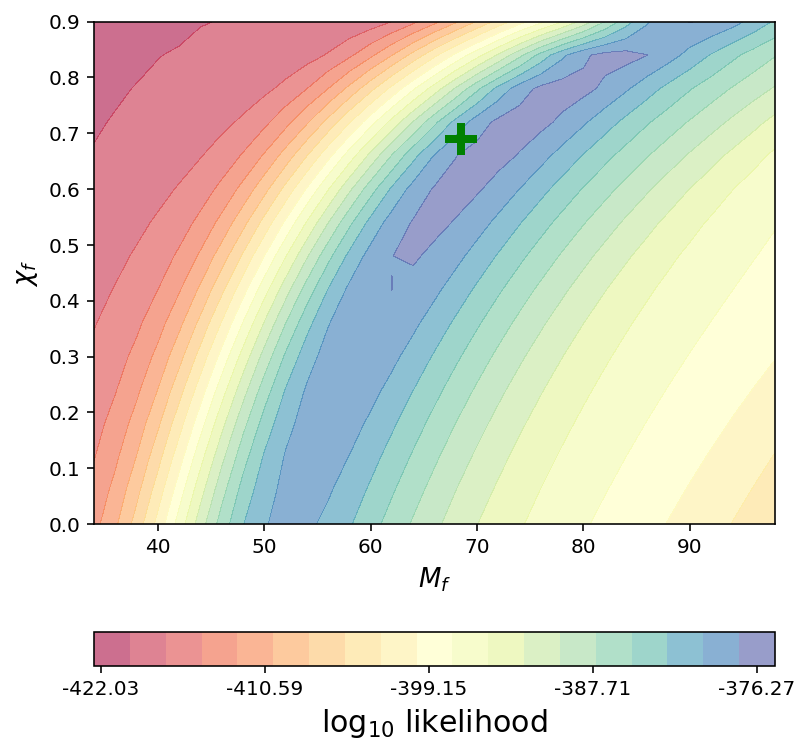

In [31]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(X, Y, finalfinal, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
ax.scatter(x=68.5, y=0.69, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\log_{10}$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(finalfinal), np.max(finalfinal), 5))

pl.xlabel(r'$M_f$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')